# Teleportation

In [12]:
from qat.lang.AQASM import *

`_a` is for Alice, `_b` is for Bob, `_c` stands for classical

In [17]:
pr = Program()
to_teleport_a = pr.qalloc()
epr_pair_a = pr.qalloc()
epr_pair_b = pr.qalloc()

epr_pair_a_c = pr.calloc()
to_teleport_a_c = pr.calloc()

Prepare the EPR pair

In [18]:
pr.apply(H, epr_pair_a)
pr.apply(CNOT, epr_pair_a, epr_pair_b)

Now Alice has her half of the EPR pair (`epr_pair_a`) and Bob the other one (`epr_pair_b`).
We prepare a random states on the qubit that Alice wants to teleport. To do so, we apply random rotations on the three axis.

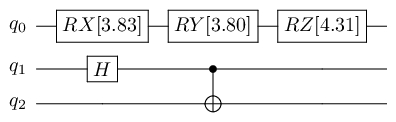

In [19]:
from random import random
from math import pi

pr.apply(RX(random() * 2 * pi), to_teleport_a)
pr.apply(RY(random() * 2 * pi), to_teleport_a)
pr.apply(RZ(random() * 2 * pi), to_teleport_a)

circ = pr.to_circ()
%qatdisplay circ

In order to show the original states contained into the `to_teleport` qubit, we clone the `Program` object. In other words, the idea is to show the state we would have obtained before the teleportation.

In [20]:
import copy
pr2 = copy.deepcopy(pr)

Let's try to simulate the original program and see what we obain.

In [21]:
from qat.qpus import PyLinalg

qpu = PyLinalg()

res = qpu.submit(circ.to_job())
for sample in res:
    print(f"State {sample.state} with amplitude {sample.amplitude}")

State |0>|0>|0> with amplitude (0.48217263021749424-0.4119332031274916j)
State |0>|1>|1> with amplitude (0.48217263021749424-0.4119332031274916j)
State |1>|0>|0> with amplitude (-0.05509256403585444-0.3078723765105007j)
State |1>|1>|1> with amplitude (-0.05509256403585444-0.3078723765105007j)


It is more useful for use to measure only the probability of the `to_teleport` register.

In [22]:
res = qpu.submit(circ.to_job(qubits=[to_teleport_a]))
for sample in res:
    print(f"State {sample.state} with probability {sample.probability}")

State |0> with probability 0.8043588183394634
State |1> with probability 0.19564118166053643


Let's proceed to teleport the state. We will continue to apply our gates to the cloned Program `pr2`.

First Alice interacts her `to_teleport` qubit with her half of the EPR pair.

In [24]:
pr2.apply(CNOT, to_teleport_a, epr_pair_a)
pr2.apply(H, to_teleport_a)
pr2.measure(to_teleport_a, to_teleport_a_c)
pr2.measure(epr_pair_a, epr_pair_a_c)

Then she sends her measured qubits to Bob which, depeding on their value being 0 or 1, performes the classically controlled `X` and `Z` operations on his own half of the EPR pair.

In [27]:
pr2.cc_apply(epr_pair_a_c, X, epr_pair_b)
pr2.cc_apply(to_teleport_a_c, Z, epr_pair_b)

circ2 = pr2.to_circ()

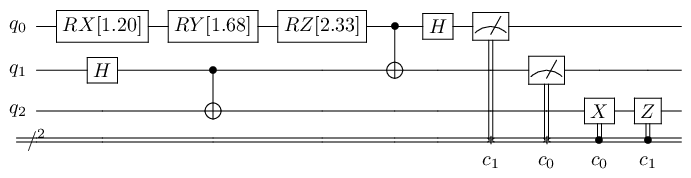

In [10]:
%qatdisplay circ2

Time to simulate

In [29]:
res2 = qpu.submit(circ2.to_job(qubits=[epr_pair_b]))

for sample in res2:
    print(f"State {sample.state} with probability {sample.probability}")

State |0> with probability 0.19564118166053646
State |1> with probability 0.8043588183394637
